# NLP Techniques
## Input -> clean data, check if the data makes sense
## NLP Techniques -> specifically designed for text data
## Output -> plot can help to check if we have what we are looking for

### 1) Sentiment Analysis
### We use the Corpus(original text) to have all words
### We use TextBlob (nltk)
### We use Naive Bayes (statistical methods)

In [7]:
#                   Polarity                                        Subjectivity
#   -1(Negative) <----------->(Positive)+1      0(Objective-fact)<---------------->(Subjective-Opion+1)



from textblob import TextBlob
TextBlob("I love Python").sentiment
TextBlob("great").sentiment # it took the average of the word great
TextBlob("not great").sentiment # generally when the word not is infront of word it is Negative

Sentiment(polarity=-0.4, subjectivity=0.75)

In [8]:
import pandas as pd
data = pd.read_pickle('files\\corpus.pkl')
#df_data_clean['transcript']['Dave']
pol = lambda x: TextBlob(x).sentiment.polarity
sub = lambda x: TextBlob(x).sentiment.subjectivity

data['Polarity'] = data['transcript'].apply(pol)
data['Subjectivity'] = data['transcript'].apply(sub)
data
        

,transcript,Polarity,Subjectivity
Ali,"Ladies and gentlemen, please welcome to the st...",0.073419,0.491160
Dave,"Original air date: November 07, 2020 [Anno...",0.072256,0.508197
Ronny,[“The Evening Primrose (Ye Lai Xiang)” by Li X...,0.111781,0.468166
Russel,[TYPING] [CHEERING] NARRATOR: Ladies and gentl...,0.040647,0.521445


Text(0, 0.5, 'Fact <----------->Opion\nSubjectivity')

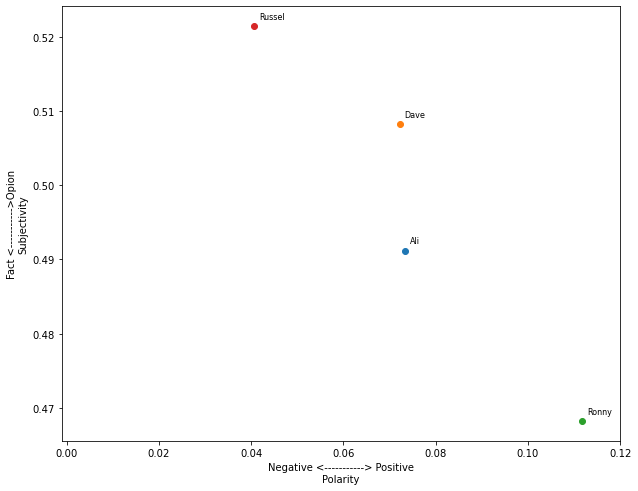

In [9]:
# Lets plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
for comedian in data.index:
    x =  data['Polarity'][comedian]
    y = data['Subjectivity'][comedian]
    plt.text(x+.001,y+.001, comedian, fontsize=8)
    plt.xlim(-.001,.12)
    plt.scatter(x,y)
plt.xlabel(f"Negative <-----------> Positive\nPolarity")
plt.ylabel(f"Fact <----------->Opion\nSubjectivity")

### 2) Topic Modeling
### We use the Document-Term Matrix(words) the order does not matter
### We use gensim
### We use Latent Dirichlet Allocation(LDA) L(hidden), D(type of probability distribution)
### We use nltk for some parts of speech tagging

#### Example
#### I like bananas and oranges             Topic A - 100%
#### Frogs and fish live in ponds           Topic B - 100%
#### Kittens and puppies are fluffy         Topic B - 100%
#### I had spinach and apple smothie        Topic A - 100%
#### My kitten loves kale                   Topic A -  60% and Topic B - 40% 

#### Topic A-> 40% banana, 30% kale, 10% breakfast...       Food
#### TOpic B-> 30% kitten, 20% puppy, 10% frog, 5% cute...  Animal

#### Every document is a mix of Topics
#### Every topic is a mix of words

In [10]:
# Using gensin to do all the work behind the separation of topic and words
# We need to inform the document-term matrix, number of topics and number of iterations
data = pd.read_pickle('files\\dtm_stop.pkl')
data

,able,absolutely,absorb,abuela,abundance,abuse,accent,accept,acceptable,access,...,york,young,younger,zero,zhong,zipped,zodiac,zone,zones,zoom
Ali,0,0,1,1,0,0,0,1,1,0,...,0,3,1,2,0,0,0,1,0,0
Dave,0,0,0,0,0,0,2,0,0,0,...,2,2,0,0,0,0,0,0,0,2
Ronny,0,0,0,0,3,0,0,1,0,0,...,22,0,0,1,1,1,0,1,1,0
Russel,4,1,0,0,0,1,0,1,0,1,...,0,1,2,0,0,0,1,0,0,0


In [11]:
# to use gensim first install -> conda install -c conda-forge gensim
from gensim import matutils, models
import scipy.sparse
tdm = data.transpose()
tdm.head()

,Ali,Dave,Ronny,Russel
able,0,0,0,4
absolutely,0,0,0,1
absorb,1,0,0,0
abuela,1,0,0,0
abundance,0,0,3,0


In [12]:
# we need to put the document-term matrix into a new gensim format
# from df -> sparse matrix
sparse_counts = scipy.sparse.csr_matrix(tdm)
corpus = matutils.Sparse2Corpus(sparse_counts)
corpus

In [14]:
# gensim requires dictionary of the all terms and theirs respective location in the term-document matrix
import pickle

cv = pickle.load(open("files\\cv_stop.pkl","rb"))
id2word = dict((v,k) for k, v in cv.vocabulary_.items())

# Attempt #1 - Topics in generall

In [15]:
# now we need to specify 2 other parameters as well
# the number of topics and the number of passes
lda = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=4, passes=10)
lda.print_topics()

[(0,
  '0.001*"goes" + 0.000*"baby" + 0.000*"black" + 0.000*"think" + 0.000*"indian" + 0.000*"tell" + 0.000*"white" + 0.000*"fucking" + 0.000*"need" + 0.000*"make"'),
 (1,
  '0.000*"black" + 0.000*"goes" + 0.000*"way" + 0.000*"white" + 0.000*"america" + 0.000*"think" + 0.000*"ll" + 0.000*"ve" + 0.000*"need" + 0.000*"guy"'),
 (2,
  '0.012*"black" + 0.009*"remember" + 0.008*"white" + 0.007*"guy" + 0.007*"life" + 0.007*"mask" + 0.006*"way" + 0.006*"helicopter" + 0.006*"coronavirus" + 0.005*"ve"'),
 (3,
  '0.008*"goes" + 0.006*"fucking" + 0.005*"indian" + 0.005*"america" + 0.005*"need" + 0.004*"baby" + 0.004*"way" + 0.004*"think" + 0.004*"ll" + 0.004*"make"')]

# Attempt #2 - Only Nouns

In [16]:
# create a function to pull out nouns from a string of text
from nltk import word_tokenize, pos_tag

def nouns(text):
    '''Give a string of text, tokenize the text and pull out only the nouns'''
    is_noun = lambda pos:pos[:2] == "NN"
    tokenized = word_tokenize(text)
    all_nouns = [word for word,pos in pos_tag(tokenized) if is_noun(pos)]
    return ' '.join(all_nouns)

In [18]:
# read the cleaned data, before the CounterVectorizer step
data_clean = pd.read_pickle('files\\data_clean.pkl')
data_clean

,transcript,fullname
Ali,ladies and gentlemen please welcome to the sta...,Ali Wong
Dave,original air date november ladies and g...,Dave Johns
Ronny,ladies and gentlemen ronny chieng thank ...,Ronny Belford
Russel,narrator ladies and gentlemen it’s start tim...,Russel Raise


In [19]:
# apply the nouns function to the transcript to filter only nouns
data_nouns = pd.DataFrame(data_clean.transcript.apply(nouns))
data_nouns

,transcript
Ali,ladies gentlemen stage ali y y ’ t gon ’ ’ osi...
Dave,air date november ladies gentlemen chappelle d...
Ronny,ladies gentlemen chieng get guys kind thank vi...
Russel,narrator ladies gentlemen ’ start time dome st...


In [20]:
# now whe know some other stopwords related to the nouns
# Lets update our document-term matrix with the new list of stop words
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer

# another word to stopwords
add_stop_words = ['like','im','know','just','thats','people','youre','think','yeah','said','year','years','yes']

# add new stop words
stop_words = text.ENGLISH_STOP_WORDS.union(add_stop_words)

# re-create document-term matrix
cvn = CountVectorizer(stop_words=stop_words) # using the new stopwords
data_cvn = cvn.fit_transform(data_nouns.transcript)  # apply into column transcript
data_dtmn = pd.DataFrame(data_cvn.toarray(),columns=cvn.get_feature_names()) # create another df with the words and frequency
data_dtmn.index = data_nouns.index # use the index from df 
data_dtmn

,abundance,abuse,accent,access,account,accountability,accounts,ace,act,action,...,yank,yard,yards,yelp,yo,yoga,yogurt,york,zone,zoom
Ali,0,0,0,0,3,0,0,0,0,0,...,1,0,0,0,0,1,0,0,1,0
Dave,0,0,2,0,2,0,2,0,0,0,...,0,2,0,0,0,0,0,2,0,2
Ronny,3,0,0,0,0,0,0,1,0,3,...,0,0,1,1,12,0,0,22,1,0
Russel,0,1,0,1,0,1,0,0,2,0,...,0,0,0,0,4,0,12,0,0,0


In [21]:
# create the gensim corpus
corpusn = matutils.Sparse2Corpus(scipy.sparse.csr_matrix(data_dtmn.transpose()))

# create the vocabulary dictionary
id2wordn = dict((v,k) for k,v in cvn.vocabulary_.items())

In [22]:
# lets start with 4 topics
ldan = models.LdaModel(corpus=corpusn, num_topics=4, id2word=id2wordn, passes=10)
ldan.print_topics()

[(0,
  '0.014*"man" + 0.014*"guy" + 0.014*"life" + 0.014*"mask" + 0.011*"way" + 0.011*"coronavirus" + 0.011*"helicopter" + 0.009*"day" + 0.008*"time" + 0.008*"house"'),
 (1,
  '0.001*"time" + 0.001*"way" + 0.001*"shit" + 0.001*"day" + 0.001*"baby" + 0.001*"man" + 0.001*"right" + 0.001*"guy" + 0.001*"peters" + 0.001*"kids"'),
 (2,
  '0.014*"time" + 0.010*"america" + 0.010*"fuck" + 0.010*"way" + 0.008*"right" + 0.007*"wife" + 0.007*"parents" + 0.007*"shit" + 0.007*"train" + 0.007*"don"'),
 (3,
  '0.020*"baby" + 0.010*"husband" + 0.010*"shit" + 0.008*"day" + 0.008*"time" + 0.007*"mom" + 0.007*"man" + 0.007*"lot" + 0.006*"pussy" + 0.005*"fuck"')]

# Attempt #3 - Only Nouns/Adjectives

In [23]:
def nouns_adj(text):
    '''Give a string of text, tokenize the text and pull out only the nouns or adjetives'''
    is_noun_adj = lambda pos:pos[:2] == "NN" or pos[:2] == "JJ"
    tokenized = word_tokenize(text)
    nouns_adj = [word for word,pos in pos_tag(tokenized) if is_noun_adj(pos)]
    return ' '.join(nouns_adj)

In [24]:
# apply the nouns function to the transcript to filter only nouns or adjetives
data_nouns_adj = pd.DataFrame(data_clean.transcript.apply(nouns_adj))
data_nouns_adj

,transcript
Ali,ladies gentlemen welcome stage ali y y wasn ’ ...
Dave,original air date november ladies gentlemen ch...
Ronny,ladies gentlemen chieng ta get ta guys s kind ...
Russel,narrator ladies gentlemen ’ s start time dome ...


In [25]:
# create a new document-term matrix using only nouns and adjectives, remore common words
# re-create document-term matrix
cvna = CountVectorizer(stop_words=stop_words, max_df=.8) # using the new stopwords
data_cvna = cvna.fit_transform(data_nouns_adj.transcript)  # apply into column transcript
data_dtmna = pd.DataFrame(data_cvna.toarray(),columns=cvna.get_feature_names()) # create another df with the words and frequency
data_dtmna.index = data_nouns_adj.index # use the index from df 
data_dtmna

,able,abuela,abundance,abuse,accent,acceptable,access,account,accountability,accounts,...,yo,yoga,yogurt,york,young,younger,zhong,zodiac,zone,zoom
Ali,0,1,0,0,0,1,0,3,0,0,...,0,1,0,0,3,1,0,0,1,0
Dave,0,0,0,0,2,0,0,2,0,2,...,0,0,0,2,2,0,0,0,0,2
Ronny,0,0,3,0,0,0,0,0,0,0,...,13,0,0,22,0,0,1,0,1,0
Russel,4,0,0,1,0,0,1,0,1,0,...,4,0,12,0,1,2,0,1,0,0


In [26]:
# create the gensim corpus
corpusna = matutils.Sparse2Corpus(scipy.sparse.csr_matrix(data_dtmna.transpose()))

# create the vocabulary dictionary
id2wordna = dict((v,k) for k,v in cvna.vocabulary_.items())

In [27]:
# lets start with 4 topics
ldana = models.LdaModel(corpus=corpusna, num_topics=4, id2word=id2wordna, passes=10)
ldana.print_topics()

[(0,
  '0.001*"fuck" + 0.001*"indian" + 0.001*"guy" + 0.001*"america" + 0.001*"wife" + 0.001*"state" + 0.001*"okay" + 0.001*"fucking" + 0.001*"russell" + 0.001*"shit"'),
 (1,
  '0.018*"baby" + 0.009*"shit" + 0.009*"husband" + 0.007*"pussy" + 0.007*"mom" + 0.006*"dick" + 0.005*"fuck" + 0.004*"okay" + 0.004*"girl" + 0.004*"ali"'),
 (2,
  '0.021*"indian" + 0.011*"russell" + 0.010*"peters" + 0.010*"ok" + 0.009*"nose" + 0.009*"son" + 0.008*"fact" + 0.008*"fuck" + 0.008*"india" + 0.008*"shit"'),
 (3,
  '0.015*"america" + 0.009*"okay" + 0.008*"guy" + 0.008*"fuck" + 0.008*"train" + 0.008*"york" + 0.008*"wife" + 0.008*"state" + 0.007*"chinese" + 0.007*"asian"')]

# Identify Topics in Each Document

In [28]:
# Our final LDA model
ldna = models.LdaModel(corpus=corpusna, num_topics=4, id2word=id2wordna, passes=80)
ldana.print_topics()

[(0,
  '0.001*"fuck" + 0.001*"indian" + 0.001*"guy" + 0.001*"america" + 0.001*"wife" + 0.001*"state" + 0.001*"okay" + 0.001*"fucking" + 0.001*"russell" + 0.001*"shit"'),
 (1,
  '0.018*"baby" + 0.009*"shit" + 0.009*"husband" + 0.007*"pussy" + 0.007*"mom" + 0.006*"dick" + 0.005*"fuck" + 0.004*"okay" + 0.004*"girl" + 0.004*"ali"'),
 (2,
  '0.021*"indian" + 0.011*"russell" + 0.010*"peters" + 0.010*"ok" + 0.009*"nose" + 0.009*"son" + 0.008*"fact" + 0.008*"fuck" + 0.008*"india" + 0.008*"shit"'),
 (3,
  '0.015*"america" + 0.009*"okay" + 0.008*"guy" + 0.008*"fuck" + 0.008*"train" + 0.008*"york" + 0.008*"wife" + 0.008*"state" + 0.007*"chinese" + 0.007*"asian"')]

### Topics
#### Topic 0: train,wife,chinese,asian
#### Topic 1: indian, russel, asian, chinese
#### Topic 2: coronavirus, mask, helicopter, president, meeting, cold
#### Topic 3: indian, russel, nose, son, india

In [30]:
# Now, take a look at which topic each transcript contains
corpus_transformed = ldana[corpusna]
list(zip([a for [(a,b)] in corpus_transformed], data_dtmna.index))

[(1, 'Ali'), (3, 'Dave'), (3, 'Ronny'), (2, 'Russel')]

### Topics
#### Topic 0: train,wife,chinese,asian                                      ->Ronny
#### Topic 1: indian, russel, asian, chinese                                ->Nobody
#### Topic 2: coronavirus, mask, helicopter, president, meeting, cold       ->Dave
#### Topic 3: indian, russel, nose, son, india                              ->Russel